In [1]:
import numpy as np
import pandas as pd
import torch

In [2]:
# class encoder(torch.nn.Module):
#     """
#     Initialize an RNN encoder:
#     x_len: The length of an input sequence. Each ECG example has length 5000.
#     x_dim: The dimension of the input sequence at each time step. At each time step 
#         we have 12 numbers (one for each lead), so this is 12.
#     h_dim: The number of hidden units in the RNN.
#     n_lyr: The number of layers to use in the RNN. 
#     """
#     def __init__(self, x_len, x_dim, h_dim, n_lyr):
#         super().__init__()
#         # self.bn = torch.nn.BatchNorm1d(x_dim)
#         self.rnn = torch.nn.RNN(x_dim, h_dim, n_lyr)
    
#     """
#     Compute the forward pass. 
#     x: Input tensor of size (x_len, N, x_dim), where N is the number of examples in the batch.
    
#     Returns z, a tensor of size (x_len, N, h_dim), containing the hidden states computed at each time step.
#     """
#     def forward(self, x):
#         # x = self.bn(torch.permute(x, (1, 2, 0))) # (L, N, C) -> (N, C, L)
#         # x = torch.permute(x, (2, 0, 1)) # (N, C, L) -> (L, N, C)
#         z, _ = self.rnn(x)
#         return z

# class decoder(torch.nn.Module):
    
#     def __init__(self, x_len, x_dim, h_dim, n_lyr):
#         super().__init__()
#         # self.bn = torch.nn.BatchNorm1d(h_dim)
#         self.rnn = torch.nn.RNN(h_dim, x_dim, n_lyr)
        
#     def forward(self, z):
#         # z = self.bn(torch.permute(z, (1, 2, 0))) # (L, N, C) -> (N, C, L)
#         # z = torch.permute(z, (2, 0, 1)) # (N, C, L) -> (L, N, C)
#         r, _ = self.rnn(z)
#         return r

In [3]:
# class encoder(torch.nn.Module):
    
#     """
#     Initialize an RNN encoder:
#     x_len: The length of an input sequence. Each ECG example has length 5000.
#     x_dim: The dimension of the input sequence at each time step. At each time step 
#         we have 12 numbers (one for each lead), so this is 12.
#     h_dim: The number of hidden units in the RNN. 
#     """
#     def __init__(self, x_len, x_dim, h_dim):
#         super().__init__()
#         self.x_len = x_len
#         self.x_dim = x_dim
#         self.h_dim = h_dim
#         #self.bn = torch.nn.BatchNorm1d(x_dim)
#         self.rnn_cell = torch.nn.RNNCell(x_dim, h_dim, nonlinearity="relu")
    
#     """
#     Compute the forward pass. 
#     x: Input tensor of size (x_len, N, x_dim), where N is the number of examples in the batch.
    
#     Returns a tensor of size (N, h_dim), containing the last hidden state.
#     """
#     def forward(self, x):
#         # Create a tensor to append the hidden states to: (1, batch_size, h_dim)
#         # The first dimension starts at 1 because we start with one null hidden state.
#         hx_s = torch.zeros((1, x.shape[1], self.h_dim))

#         for t in range(1, self.x_len):
#             hx = self.rnn_cell(x[t,:,:], hx_s[t-1,:,:])
#             hx = torch.reshape(hx, (1, x.shape[1], self.h_dim))
#             hx_s = torch.cat((hx_s, hx), 0)

#         return hx_s[-1,:,:]

# class decoder(torch.nn.Module):
    
#     """
#     Initialize an RNN decoder:
#     x_len: The length of an input sequence. Each ECG example has length 5000.
#     x_dim: The dimension of the input sequence at each time step. At each time step 
#         we have 12 numbers (one for each lead), so this is 12.
#     h_dim: The number of hidden units in the RNN. 
#     """
#     def __init__(self, x_len, x_dim, h_dim):
#         super().__init__()
#         self.x_len = x_len
#         self.x_dim = x_dim
#         self.h_dim = h_dim
#         #self.bn = torch.nn.BatchNorm1d(h_dim)
#         self.rnn_cell = torch.nn.RNNCell(x_dim, h_dim, nonlinearity="relu")
#         self.linear = torch.nn.Linear(h_dim, x_dim)
        
#     def forward(self, hx):
#         batch_size = hx.shape[0]
        
#         # Create a tensor to append the hidden states to: (0, batch_size, h_dim)
#         hx_s = torch.zeros((0, batch_size, self.h_dim))

#         # Append the last hidden state of the encoder as our 0th hidden state.
#         hx = torch.reshape(hx, (1, batch_size, self.h_dim))
#         hx_s = torch.cat((hx_s, hx), 0)

#         # Create a tensor to store the decoder outputs.
#         outputs = torch.ones((1, batch_size, self.x_dim))
        
#         for t in range(1, self.x_len+1):
#             # Get the next hidden state from the decoder.
#             hx = self.rnn_cell(outputs[t-1,:,:], hx_s[t-1,:,:])
#             hx = torch.reshape(hx, (1, batch_size, self.h_dim))
#             hx_s = torch.cat((hx_s, hx), 0)
  
#             # Get the next output by applying a linear layer. 
#             out = self.linear(hx_s[t,:,:])
#             out = torch.reshape(out, (1, batch_size, self.x_dim))
#             outputs = torch.cat((outputs, out), 0)
        
#         # print("hx_s: ", hx_s)
        
#         return outputs[1:self.x_len+1,:,:]
    
# class autoencoder(torch.nn.Module):
    
#     def __init__(self, x_len = 5000, x_dim = 12, h_dim = 6):
#         super().__init__()
#         self.enc = encoder(x_len, x_dim, h_dim)
#         self.dec = decoder(x_len, x_dim, h_dim)
    
#     def forward(self, x):
#         hx = self.enc(x)
#         r = self.dec(hx)
#         return r

In [150]:
# class encoder(torch.nn.Module):
    
#     """
#     Initialize an RNN encoder:
#     x_len: The length of an input sequence. Each ECG example has length 5000.
#     x_dim: The dimension of the input sequence at each time step. At each time step 
#         we have 12 numbers (one for each lead), so this is 12.
#     h_dim: The number of hidden units in the RNN. 
#     """
#     def __init__(self, x_len, x_dim, h_dim, n_lyr):
#         super().__init__()
#         self.x_len = x_len
#         self.x_dim = x_dim
#         self.h_dim = h_dim
#         self.n_lyr = n_lyr
        
#         # add RNN layers. First layer takes x_dim input vectors. Remaining layers
#         # take hidden states as input.
#         self.rnn_cells = [torch.nn.RNNCell(x_dim, h_dim, nonlinearity="relu")]
#         for _ in range(n_lyr-1):
#             cell = torch.nn.RNNCell(h_dim, h_dim, nonlinearity="relu")
#             self.rnn_cells.append(cell)
    
#     """
#     x_t: Input at some time-step of shape (batch_size, x_dim).
#     hx_s: Hidden states at previous time-step of shape (n_lyr, batch_size, h_dim).
    
#     returns hx_s_t: a tensor containing the next hidden states for each layer of shape (n_lyr, batch_size, h_dim).
#     """
#     def rnn_forward(self, x_t, hx_s):
        
#         batch_size = x_t.shape[0]
        
#         hx_s_t = torch.zeros((0, batch_size, self.h_dim)) # hidden states
#         in_s_t = torch.zeros((0, batch_size, self.h_dim)) # layer inputs
        
#         # Pass x_t through the first RNN layer.
#         hx_t = self.rnn_cells[0](x_t, hx_s[0,:,:])
#         hx_t = torch.reshape(hx_t, (1, batch_size, self.h_dim))
#         hx_s_t = torch.cat((hx_s_t, hx_t)) # store the hidden state
#         in_s_t = torch.cat((in_s_t, hx_t)) # store also as an input to the next layer.
        
#         # Propagate up through the remaining RNN layers.
#         for i in range(1, self.n_lyr):
#             hx_t = self.rnn_cells[i](in_s_t[i-1,:,:], hx_s[i,:,:])
#             hx_t = torch.reshape(hx_t, (1, batch_size, self.h_dim))
#             hx_s_t = torch.cat((hx_s_t, hx_t)) # store the hidden state
#             in_s_t = torch.cat((in_s_t, hx_t)) # store also as an input to the next layer.
            
#         return hx_s_t
    
#     """
#     Compute the forward pass. 
#     x: Input tensor of size (x_len, N, x_dim), where N is the number of examples in the batch.
    
#     Returns a tensor of size (N, h_dim), containing the last hidden state of the last layer.
#     """
#     def forward(self, x):
#         batch_size = x.shape[1]
#         hx_s = torch.zeros((self.n_lyr, batch_size, self.h_dim))
#         for t in range(0, self.x_len):
#             hx_s = self.rnn_forward(x[t,:,:], hx_s)
#         #return hx_s[-1,:,:]
#         return hx_s

# class decoder(torch.nn.Module):
    
#     """
#     Initialize an RNN decoder:
#     x_len: The length of an input sequence. Each ECG example has length 5000.
#     x_dim: The dimension of the input sequence at each time step. At each time step 
#         we have 12 numbers (one for each lead), so this is 12.
#     h_dim: The number of hidden units in the RNN. 
#     """
#     def __init__(self, x_len, x_dim, h_dim, n_lyr):
#         super().__init__()
#         self.x_len = x_len
#         self.x_dim = x_dim
#         self.h_dim = h_dim
#         self.n_lyr = n_lyr
        
#         # add RNN layers. First layer takes x_dim input vectors. Remaining layers
#         # take hidden states as input.
#         self.rnn_cells = [torch.nn.RNNCell(x_dim, h_dim, nonlinearity="relu")]
#         for _ in range(n_lyr-1):
#             cell = torch.nn.RNNCell(h_dim, h_dim, nonlinearity="relu")
#             self.rnn_cells.append(cell)
            
#         # Linear layer to compute RNN outputs.
#         self.linear = torch.nn.Linear(h_dim, x_dim)
    
#     """
#     x_t: Input at some time-step of shape (batch_size, x_dim).
#     hx_s: Hidden states at previous time-step of shape (n_lyr, batch_size, h_dim).
    
#     returns hx_s_t: a tensor containing the next hidden states for each layer of shape (n_lyr, batch_size, h_dim).
#     """
#     def rnn_forward(self, x_t, hx_s):
        
#         batch_size = x_t.shape[0]
        
#         hx_s_t = torch.zeros((0, batch_size, self.h_dim)) # hidden states
#         in_s_t = torch.zeros((0, batch_size, self.h_dim)) # layer inputs
        
#         # Pass x_t through the first RNN layer.
#         hx_t = self.rnn_cells[0](x_t, hx_s[0,:,:])
#         hx_t = torch.reshape(hx_t, (1, batch_size, self.h_dim))
#         hx_s_t = torch.cat((hx_s_t, hx_t)) # store the hidden state
#         in_s_t = torch.cat((in_s_t, hx_t)) # store also as an input to the next layer.
        
#         # Propagate up through the remaining RNN layers.
#         for i in range(1, self.n_lyr):
#             hx_t = self.rnn_cells[i](in_s_t[i-1,:,:], hx_s[i,:,:])
#             hx_t = torch.reshape(hx_t, (1, batch_size, self.h_dim))
#             hx_s_t = torch.cat((hx_s_t, hx_t)) # store the hidden state
#             in_s_t = torch.cat((in_s_t, hx_t)) # store also as an input to the next layer.
            
#         return hx_s_t

#     def forward(self, hx):
        
#         #batch_size = hx.shape[0]
#         batch_size = hx.shape[1]
        
#         # store the outputs.
#         outputs = torch.zeros((0, batch_size, self.x_dim)) 
        
#         # initialize the hidden states for each layer.
#         #hx_s = torch.zeros((self.n_lyr-1, batch_size, self.h_dim))
#         hx_s = hx
        
#         # prepend hx as our 0th hidden state to the first layer.
#         #hx = torch.reshape(hx, (1, batch_size, self.h_dim))
#         #hx_s = torch.cat((hx, hx_s), 0) 
        
#         # first input is zeros.
#         x_t = torch.zeros((batch_size, x_dim)) 
        
#         for t in range(0, self.x_len):
#             # get next hidden states.
#             hx_s = self.rnn_forward(x_t, hx_s)
            
#             # pass the hidden state of the last RNN layer through 
#             # a linear layer to get the output.
#             y_t = self.linear(hx_s[-1,:,:])
#             out = torch.reshape(y_t, (1, batch_size, self.x_dim))
#             outputs = torch.cat((outputs, out), 0)
            
#             # the current output is the next input.
#             x_t = y_t
            
#         return outputs

# class autoencoder(torch.nn.Module):
    
#     def __init__(self, x_len = 5000, x_dim = 12, h_dim = 6, n_lyr = 1):
#         super().__init__()
#         self.enc = encoder(x_len, x_dim, h_dim, n_lyr)
#         self.dec = decoder(x_len, x_dim, h_dim, n_lyr)
    
#     def forward(self, x):
#         hx = self.enc(x)
#         r = self.dec(hx)
#         return r

In [13]:
class Encoder(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, stride=(1,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=(1,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, stride=(1,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, stride=(1,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, stride=(1,3), padding=1)
        )
        
        self.flatten = torch.nn.Flatten()
        
        self.linear = torch.nn.Linear(16128, 10000) 
    
    def forward(self, X):
        X = self.cnn(X)
        X = self.flatten(X)
        X = self.linear(X)
        return X
        
class Decoder(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear = torch.nn.Linear(10000, 16128)
        
        self.unflatten = torch.nn.Unflatten(-1, (64, 12, 21))
        
        self.cnn = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, 3, stride=(1,3), padding=1, output_padding=(0,1)),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 64, 3, stride=(1,3), padding=1, output_padding=(0,2)),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 64, 3, stride=(1,3), padding=1, output_padding=(0,0)),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, 3, stride=(1,3), padding=1, output_padding=(0,1)),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, 3, stride=(1,3), padding=1, output_padding=(0,1))
        )
    
    def forward(self, X):
        X = self.linear(X)
        X = self.unflatten(X)
        X = self.cnn(X)
        return X
    
class AutoEncoder(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        
    def forward(self, X):
        X = self.enc.forward(X)
        X = self.dec.forward(X)
        return X
    


In [14]:
X_0 = torch.randn(25, 1, 12, 5000)
ae = AutoEncoder()
X_1 = ae.forward(X_0)
X_1.shape

torch.Size([25, 1, 12, 5000])

In [12]:
X = torch.randn(15, 1, 12, 5000)
print(X.shape)
X = torch.nn.Conv2d(1, 32, 3, stride=(1,3), padding=1)(X)
print(X.shape)
X = torch.nn.Conv2d(32, 64, 3, stride=(1,3), padding=1)(X)
print(X.shape)
X = torch.nn.Conv2d(64, 64, 3, stride=(1,3), padding=1)(X)
print(X.shape)
X = torch.nn.Conv2d(64, 64, 3, stride=(1,3), padding=1)(X)
print(X.shape)
X = torch.nn.Conv2d(64, 64, 3, stride=(1,3), padding=1)(X)
print(X.shape)

print(torch.nn.Flatten()(X).shape)

X = torch.nn.ConvTranspose2d(64, 64, 3, stride=(1,3), padding=1, output_padding=(0,1))(X)
print(X.shape)
X = torch.nn.ConvTranspose2d(64, 64, 3, stride=(1,3), padding=1, output_padding=(0,2))(X)
print(X.shape)
X = torch.nn.ConvTranspose2d(64, 64, 3, stride=(1,3), padding=1, output_padding=(0,0))(X)
print(X.shape)
X = torch.nn.ConvTranspose2d(64, 32, 3, stride=(1,3), padding=1, output_padding=(0,1))(X)
print(X.shape)
X = torch.nn.ConvTranspose2d(32, 1, 3, stride=(1,3), padding=1, output_padding=(0,1))(X)
print(X.shape)

torch.Size([15, 1, 12, 5000])
torch.Size([15, 32, 12, 1667])
torch.Size([15, 64, 12, 556])
torch.Size([15, 64, 12, 186])
torch.Size([15, 64, 12, 62])
torch.Size([15, 64, 12, 21])
torch.Size([15, 16128])
torch.Size([15, 64, 12, 62])
torch.Size([15, 64, 12, 186])
torch.Size([15, 64, 12, 556])
torch.Size([15, 32, 12, 1667])
torch.Size([15, 1, 12, 5000])


In [4]:
from pathlib import Path
from tqdm import tqdm

def load_data(n = -1):
    data = pd.read_excel("data/Diagnostics.xlsx")
    num_examples = data.shape[0] if n == -1 else n
    
    X = np.zeros((5000, num_examples, 12))
    
    print("Loading", num_examples, "Examples.")
    for i, file in tqdm(enumerate((Path.cwd() / "data/ECGData/").glob("*.csv")), total = num_examples):
        fname = file.name
        X[:, i, :] = pd.read_csv(file).to_numpy()
        if i >= num_examples - 1:
            break
    print("Done!")
    
    X = torch.from_numpy(X).type(torch.FloatTensor)
    
    return X

import matplotlib.pyplot as plt

def plot_ecg(o, r, X_LEN, n_leads = 12):
    fig, axs = plt.subplots(n_leads, figsize=(8, 8))
    plt.xlabel("Seconds")
    plt.ylabel("Microvolts")
    plt.xlim([0, 10])
    
    x = np.linspace(0, 10, X_LEN) # 500Hz
    for i in range(n_leads):
        axs[i].plot(x, o[i,:].numpy(), color='black')
        axs[i].plot(x, r[i,:].numpy(), color='blue')
    
    plt.show()
    

In [94]:
data = pd.read_excel("data/Diagnostics.xlsx")
data.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [22]:
X = load_data(100)

X_DIM = 12
X_LEN = 5000
N_EX = 100
B_SZ = 25

# Shrink the data in accordance with above.
X = X[0:X_LEN,0:N_EX,0:X_DIM]

def reshape_for_cnn(X):
    """
    Reshapes the data from (X_LEN, B_SZ, X_DIM) (e.g. (5000, 10, 12))
    to (B_SZ, 1, X_DIM, X_LEN), because we have 1 channel.
    """
    X_LEN, B_SZ, X_DIM = X.shape
    X = torch.permute(X, (1, 2, 0))
    X = torch.reshape(X, (B_SZ, 1, X_DIM, X_LEN))
    return X

X = reshape_for_cnn(X)

ae = AutoEncoder()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr = 1e-2, weight_decay = 1e-8)

# Place on GPU
# mps_device = torch.device("mps")
# X.to(mps_device)
# ae.to(mps_device)

### Train
N_EPOCHS = 50
print("Starting training...")
for e_i in range(N_EPOCHS):
    
    # shuffle the indices
    idx = np.arange(N_EX)
    np.random.shuffle(idx)
    
    # iterate over batches
    epoch_loss = 0.0
    num_batches = N_EX // B_SZ
    for b_i in range(num_batches):
        
        # Make batch
        X_batch = X[idx[b_i * B_SZ : (b_i + 1) * B_SZ],:,:,:]
  
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward Pass
        r = ae.forward(X_batch)

        # Compute MSE loss
        loss = criterion(r, X_batch)

        # Update parameters
        loss.backward()
        optimizer.step()
        
        print(loss.item())
        
    print("Epoch #{0} Loss:{1}".format(e_i + 1, loss.item()))

Loading 100 Examples.


 99%|████████████████████████████████████████▌| 99/100 [00:00<00:00, 215.69it/s]


Done!
Starting training...
70300.5703125
7025166.5
198074.234375
56698.4921875
Epoch #1 Loss:56698.4921875
63183.13671875
73074.9765625
71109.6875
55362.26953125
Epoch #2 Loss:55362.26953125
53198.21484375
61383.44140625
53355.390625
93920.7109375
Epoch #3 Loss:93920.7109375
64940.9375
80225.4296875
61467.44921875
54931.2265625
Epoch #4 Loss:54931.2265625
55704.06640625
85017.28125
72147.1640625
48710.00390625
Epoch #5 Loss:48710.00390625
48978.19140625
59813.484375
63351.12890625
89431.4375
Epoch #6 Loss:89431.4375
58119.53125
51990.9375
90815.9140625
60646.96484375
Epoch #7 Loss:60646.96484375
50673.61328125
62893.21875
77990.0859375
70014.203125
Epoch #8 Loss:70014.203125
55626.48828125
59645.296875
85059.4609375
61237.66796875
Epoch #9 Loss:61237.66796875
61554.328125
90879.1328125
57299.25390625
51834.26953125
Epoch #10 Loss:51834.26953125
76300.078125
55754.78515625
76199.5703125
53311.12109375
Epoch #11 Loss:53311.12109375
60523.21875
56373.046875
87970.2109375
56697.65234375
Ep

KeyboardInterrupt: 

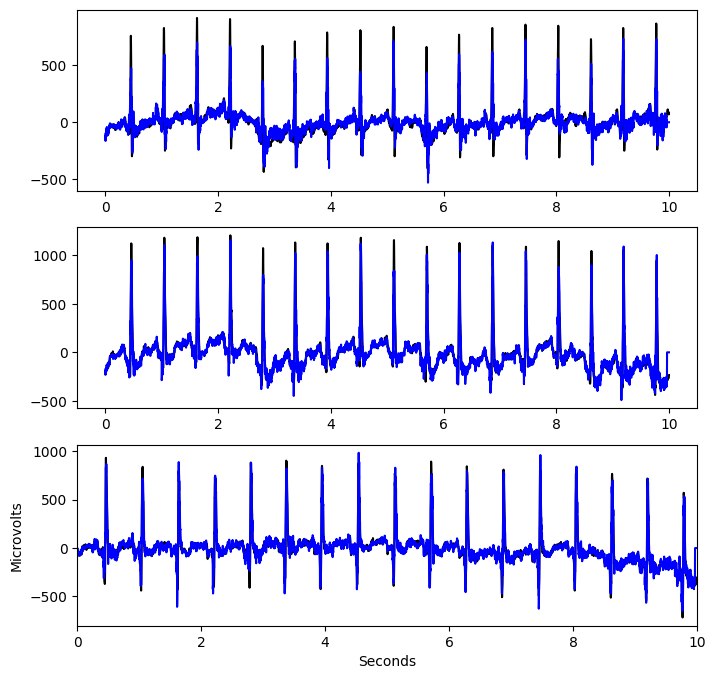

In [19]:
with torch.no_grad():
    i = 4
    o = X[i:i+1, :, :, :]
    r = ae.forward(o)
    plot_ecg(o[0, 0, :, :], r[0, 0, :, :], X_LEN, n_leads=2)

In [89]:
np.arange(N_EX)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])